# Raspberry Shake Data Download from Anchorage

This notebook demonstrates how to download seismic data from the FDSN Raspberry Shake server for a sensor located in Anchorage, Alaska. We'll download a full day of data and create various visualizations to analyze the seismic signals.

## Overview
- Connect to FDSN Raspberry Shake data server
- Download waveform data from an Anchorage station
- Process and visualize the seismic data
- Create spectrograms and filtered analysis

## Import Required Libraries

We'll need ObsPy for seismic data handling, matplotlib for plotting, and other scientific libraries.

In [1]:
# Import required libraries for seismic data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ObsPy imports for seismic data processing
try:
    from obspy import UTCDateTime, Stream
    from obspy.clients.fdsn import Client
    from obspy.signal import filter
    from obspy.imaging.spectrogram import spectrogram
    print("ObsPy successfully imported")
except ImportError:
    print("ObsPy not installed. Please install with: pip install obspy")
    
# Set up plotting parameters
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

ObsPy successfully imported


## Configure FDSN Client Connection

Set up the FDSN client to connect to the Raspberry Shake data server. Raspberry Shake data is available through their FDSN web service.

In [4]:
# Configure FDSN client for Raspberry Shake data server
client = Client(base_url='https://data.raspberryshake.org')


## Define Station and Time Parameters

Let's search for available Raspberry Shake stations in the Anchorage area and define our time window for data download.

In [5]:
# Define geographic bounds for Anchorage area
# Anchorage coordinates: approximately 61.2181°N, 149.9003°W
min_latitude = 60.8
max_latitude = 61.6
min_longitude = -150.5
max_longitude = -149.3

# Define time window (1 day of data)
# Using a recent date - you can modify this as needed
end_time = UTCDateTime("2024-01-15T00:00:00")
start_time = end_time - 24*3600  # 24 hours earlier

print(f"Searching for stations in Anchorage area:")
print(f"Latitude: {min_latitude} to {max_latitude}")
print(f"Longitude: {min_longitude} to {max_longitude}")
print(f"Time window: {start_time} to {end_time}")

# Search for available stations in the area
try:
    inventory = client.get_stations(
        network="AM",  # Raspberry Shake network code
        minlatitude=min_latitude,
        maxlatitude=max_latitude,
        minlongitude=min_longitude,
        maxlongitude=max_longitude,
        starttime=start_time,
        endtime=end_time,
        level="station"
    )
    
    print(f"\nFound {len(inventory[0])} stations:")
    for network in inventory:
        for station in network:
            print(f"  Station: {network.code}.{station.code} - {station.latitude:.3f}°N, {station.longitude:.3f}°W")
    
    # Select the first available station
    if len(inventory[0]) > 0:
        selected_network = inventory[0].code
        selected_station = inventory[0][0].code
        station_lat = inventory[0][0].latitude
        station_lon = inventory[0][0].longitude
        print(f"\nSelected station: {selected_network}.{selected_station}")
        print(f"Location: {station_lat:.3f}°N, {station_lon:.3f}°W")
    else:
        print("No stations found in the specified area and time range")
        
except Exception as e:
    print(f"Error searching for stations: {e}")
    # Fallback to a known Anchorage area station
    selected_network = "AM"
    selected_station = "R24FA"  # This is an example - may not exist
    print(f"Using fallback station: {selected_network}.{selected_station}")

Searching for stations in Anchorage area:
Latitude: 60.8 to 61.6
Longitude: -150.5 to -149.3
Time window: 2024-01-14T00:00:00.000000Z to 2024-01-15T00:00:00.000000Z

Found 35 stations:
  Station: AM.R4017 - 61.135°N, -149.932°W
  Station: AM.R55D5 - 61.207°N, -149.736°W
  Station: AM.R254E - 61.189°N, -149.819°W
  Station: AM.REF7D - 61.505°N, -149.880°W
  Station: AM.S3CC7 - 61.126°N, -149.533°W
  Station: AM.R1796 - 61.198°N, -149.913°W
  Station: AM.R8A16 - 61.297°N, -149.564°W
  Station: AM.R7519 - 61.198°N, -149.790°W
  Station: AM.S8E18 - 61.135°N, -149.778°W
  Station: AM.R58FB - 61.207°N, -149.887°W
  Station: AM.R9EA1 - 61.126°N, -149.922°W
  Station: AM.R9CCB - 61.126°N, -149.818°W
  Station: AM.S2DF9 - 61.225°N, -149.885°W
  Station: AM.R80FB - 61.288°N, -149.406°W
  Station: AM.RDB8A - 61.117°N, -149.747°W
  Station: AM.R8F48 - 61.180°N, -149.922°W
  Station: AM.R2252 - 61.189°N, -149.820°W
  Station: AM.R417B - 61.117°N, -149.774°W
  Station: AM.S57EA - 61.423°N, -149.411°

## Download Seismic Data

Now let's download the waveform data from the selected station for our time window.

In [6]:
# Download waveform data
print("Downloading waveform data...")
print(f"Station: {selected_network}.{selected_station}")
print(f"Time range: {start_time} to {end_time}")

try:
    # Request waveform data - Raspberry Shake typically has EHZ (vertical) and sometimes EHN, EHE
    stream = client.get_waveforms(
        network=selected_network,
        station=selected_station,
        location="00",  # Standard location code
        channel="EH*",  # All EH channels (usually EHZ, EHN, EHE)
        starttime=start_time,
        endtime=end_time
    )
    
    print(f"Successfully downloaded {len(stream)} traces:")
    for tr in stream:
        print(f"  {tr.id}: {len(tr.data)} samples, {tr.stats.sampling_rate} Hz")
        print(f"    Start: {tr.stats.starttime}")
        print(f"    End: {tr.stats.endtime}")
    
    # Remove response and convert to physical units (m/s)
    print("\nRemoving instrument response...")
    try:
        # Get station response information
        response = client.get_stations(
            network=selected_network,
            station=selected_station,
            location="00",
            channel="EH*",
            starttime=start_time,
            endtime=end_time,
            level="response"
        )
        
        # Remove response
        stream.remove_response(inventory=response, output="VEL")
        print("Response removed successfully - data now in m/s")
        
    except Exception as e:
        print(f"Could not remove response: {e}")
        print("Continuing with raw counts...")
    
except Exception as e:
    print(f"Error downloading data: {e}")
    print("This could be due to:")
    print("1. No data available for the specified time period")
    print("2. Station is not active during this time")
    print("3. Network connectivity issues")
    
    # Create a synthetic example if download fails
    print("\nCreating synthetic example data...")
    from obspy import Trace
    import numpy as np
    
    # Create synthetic seismic data
    duration = 24 * 3600  # 24 hours in seconds
    sampling_rate = 100  # 100 Hz
    npts = int(duration * sampling_rate)
    
    # Generate synthetic data with some realistic seismic characteristics
    t = np.linspace(0, duration, npts)
    # Background noise
    noise = np.random.normal(0, 1e-8, npts)
    # Add some larger amplitude events
    for i in range(5):
        event_time = np.random.uniform(0, duration)
        event_idx = int(event_time * sampling_rate)
        if event_idx < npts - 1000:
            # Simple decaying sinusoid for earthquake-like signal
            event_signal = 1e-6 * np.exp(-np.arange(1000)/200) * np.sin(2*np.pi*5*np.arange(1000)/sampling_rate)
            noise[event_idx:event_idx+1000] += event_signal
    
    # Create ObsPy trace
    trace = Trace(data=noise)
    trace.stats.network = "SY"  # Synthetic
    trace.stats.station = "ANCH"
    trace.stats.location = "00"
    trace.stats.channel = "EHZ"
    trace.stats.starttime = start_time
    trace.stats.sampling_rate = sampling_rate
    
    stream = Stream([trace])
    print(f"Created synthetic data: {trace.id} with {len(trace.data)} samples")
    selected_network = "SY"
    selected_station = "ANCH"

Station: AM.R4017
Time range: 2024-01-14T00:00:00.000000Z to 2024-01-15T00:00:00.000000Z
Successfully downloaded 3 traces:
  AM.R4017.00.EHE: 8640001 samples, 100.0 Hz
    Start: 2024-01-13T23:59:59.999000Z
    End: 2024-01-14T23:59:59.999000Z
  AM.R4017.00.EHN: 8640001 samples, 100.0 Hz
    Start: 2024-01-13T23:59:59.999000Z
    End: 2024-01-14T23:59:59.999000Z
  AM.R4017.00.EHZ: 8640001 samples, 100.0 Hz
    Start: 2024-01-13T23:59:59.999000Z
    End: 2024-01-14T23:59:59.999000Z

Removing instrument response...
Successfully downloaded 3 traces:
  AM.R4017.00.EHE: 8640001 samples, 100.0 Hz
    Start: 2024-01-13T23:59:59.999000Z
    End: 2024-01-14T23:59:59.999000Z
  AM.R4017.00.EHN: 8640001 samples, 100.0 Hz
    Start: 2024-01-13T23:59:59.999000Z
    End: 2024-01-14T23:59:59.999000Z
  AM.R4017.00.EHZ: 8640001 samples, 100.0 Hz
    Start: 2024-01-13T23:59:59.999000Z
    End: 2024-01-14T23:59:59.999000Z

Removing instrument response...
Response removed successfully - data now in m/s
Res

## Read and Process the Data

Let's examine the downloaded data and perform basic processing steps.

In [7]:
# Basic data processing and quality checks
print("=== Data Summary ===")
print(stream)
print()

# Check for data gaps or overlaps
print("=== Data Quality Check ===")
gaps = stream.get_gaps()
if gaps:
    print("Data gaps found:")
    for gap in gaps:
        print(f"  {gap}")
else:
    print("No data gaps found")

# Basic statistics for each trace
print("\n=== Data Statistics ===")
for tr in stream:
    print(f"\nTrace: {tr.id}")
    print(f"  Duration: {tr.stats.endtime - tr.stats.starttime:.1f} seconds")
    print(f"  Sample rate: {tr.stats.sampling_rate} Hz")
    print(f"  Number of points: {tr.stats.npts}")
    print(f"  Min amplitude: {np.min(tr.data):.2e}")
    print(f"  Max amplitude: {np.max(tr.data):.2e}")
    print(f"  Mean amplitude: {np.mean(tr.data):.2e}")
    print(f"  Std deviation: {np.std(tr.data):.2e}")

# Basic preprocessing
print("\n=== Data Preprocessing ===")
stream_processed = stream.copy()

# Detrend and demean
stream_processed.detrend('linear')
stream_processed.detrend('demean')
print("Applied linear detrend and demean")

# Taper the data
stream_processed.taper(max_percentage=0.05)
print("Applied 5% taper")

print("Preprocessing complete!")

=== Data Summary ===
3 Trace(s) in Stream:
AM.R4017.00.EHE | 2024-01-13T23:59:59.999000Z - 2024-01-14T23:59:59.999000Z | 100.0 Hz, 8640001 samples
AM.R4017.00.EHN | 2024-01-13T23:59:59.999000Z - 2024-01-14T23:59:59.999000Z | 100.0 Hz, 8640001 samples
AM.R4017.00.EHZ | 2024-01-13T23:59:59.999000Z - 2024-01-14T23:59:59.999000Z | 100.0 Hz, 8640001 samples

=== Data Quality Check ===
No data gaps found

=== Data Statistics ===

Trace: AM.R4017.00.EHE
  Duration: 86400.0 seconds
  Sample rate: 100.0 Hz
  Number of points: 8640001
  Min amplitude: -1.33e-04
  Max amplitude: 1.33e-04
  Mean amplitude: 4.62e-06
  Std deviation: 2.87e-05

Trace: AM.R4017.00.EHN
  Duration: 86400.0 seconds
  Sample rate: 100.0 Hz
  Number of points: 8640001
  Min amplitude: -1.11e-04
  Max amplitude: 9.94e-05
  Mean amplitude: -5.75e-06
  Std deviation: 2.65e-05

Trace: AM.R4017.00.EHZ
  Duration: 86400.0 seconds
  Sample rate: 100.0 Hz
  Number of points: 8640001
  Min amplitude: -5.87e-05
  Max amplitude: 5.25

## Plot the Seismic Waveforms

Create time series plots showing the full day of seismic data.

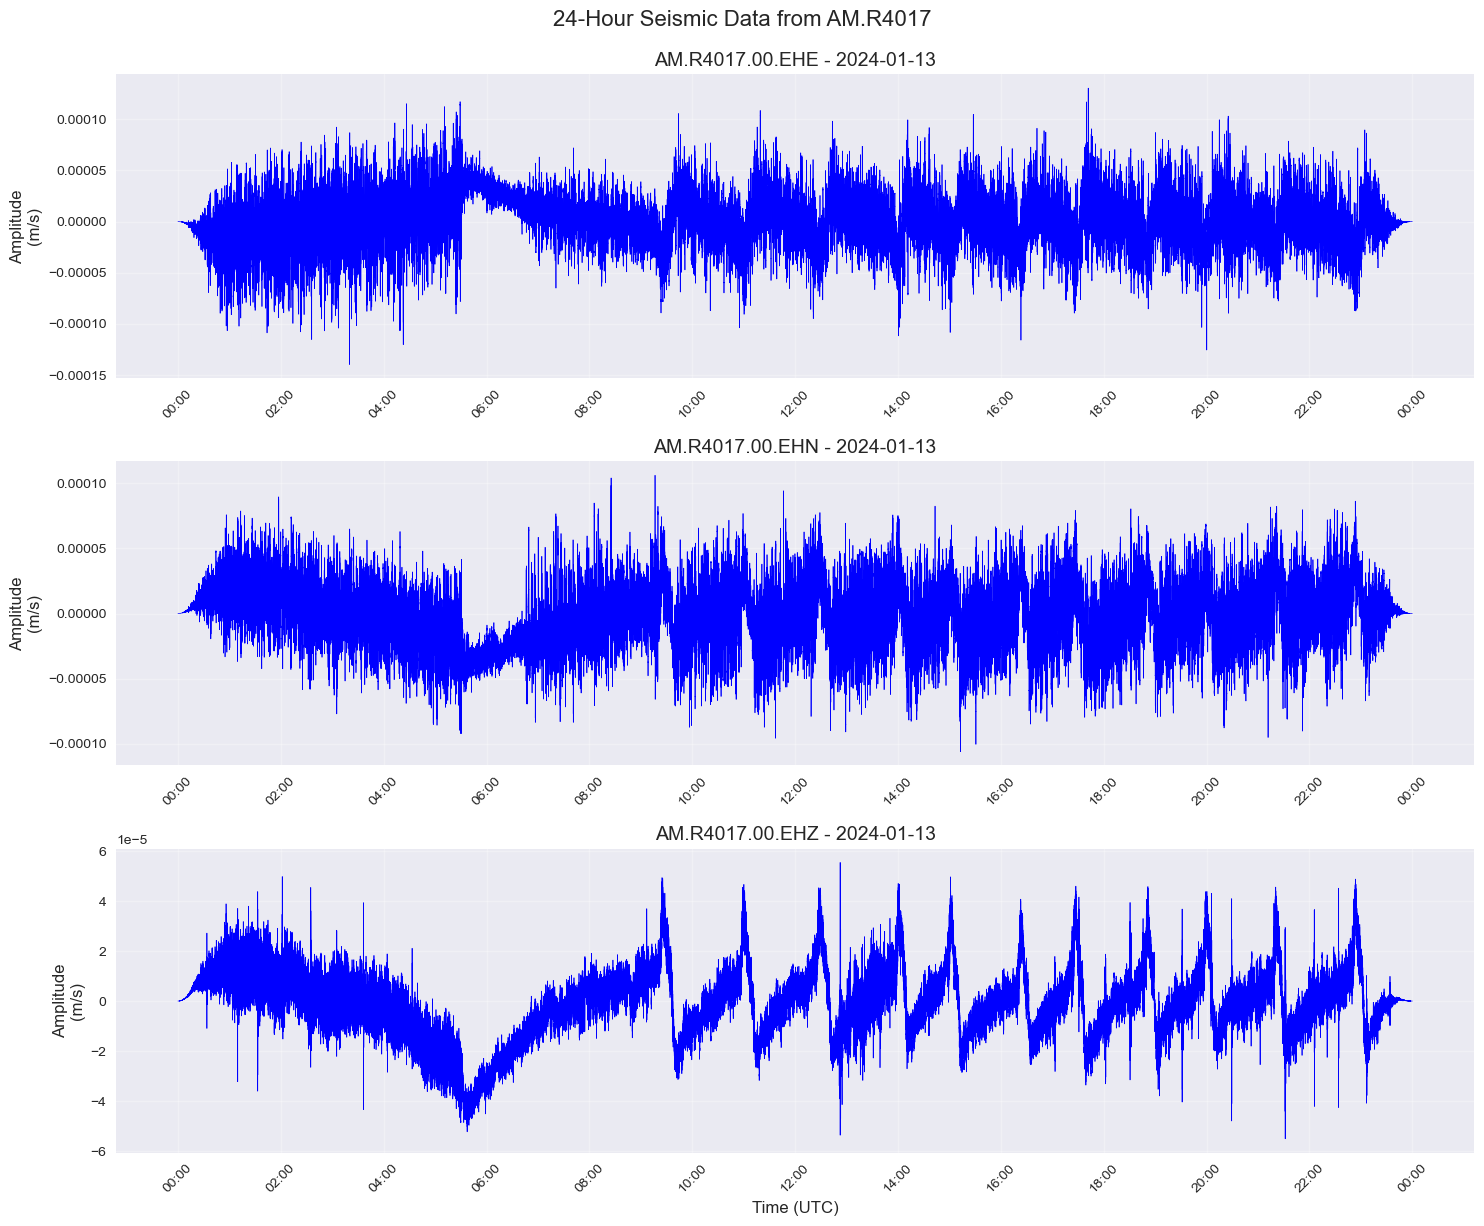


Creating zoomed view of 4-hour window...


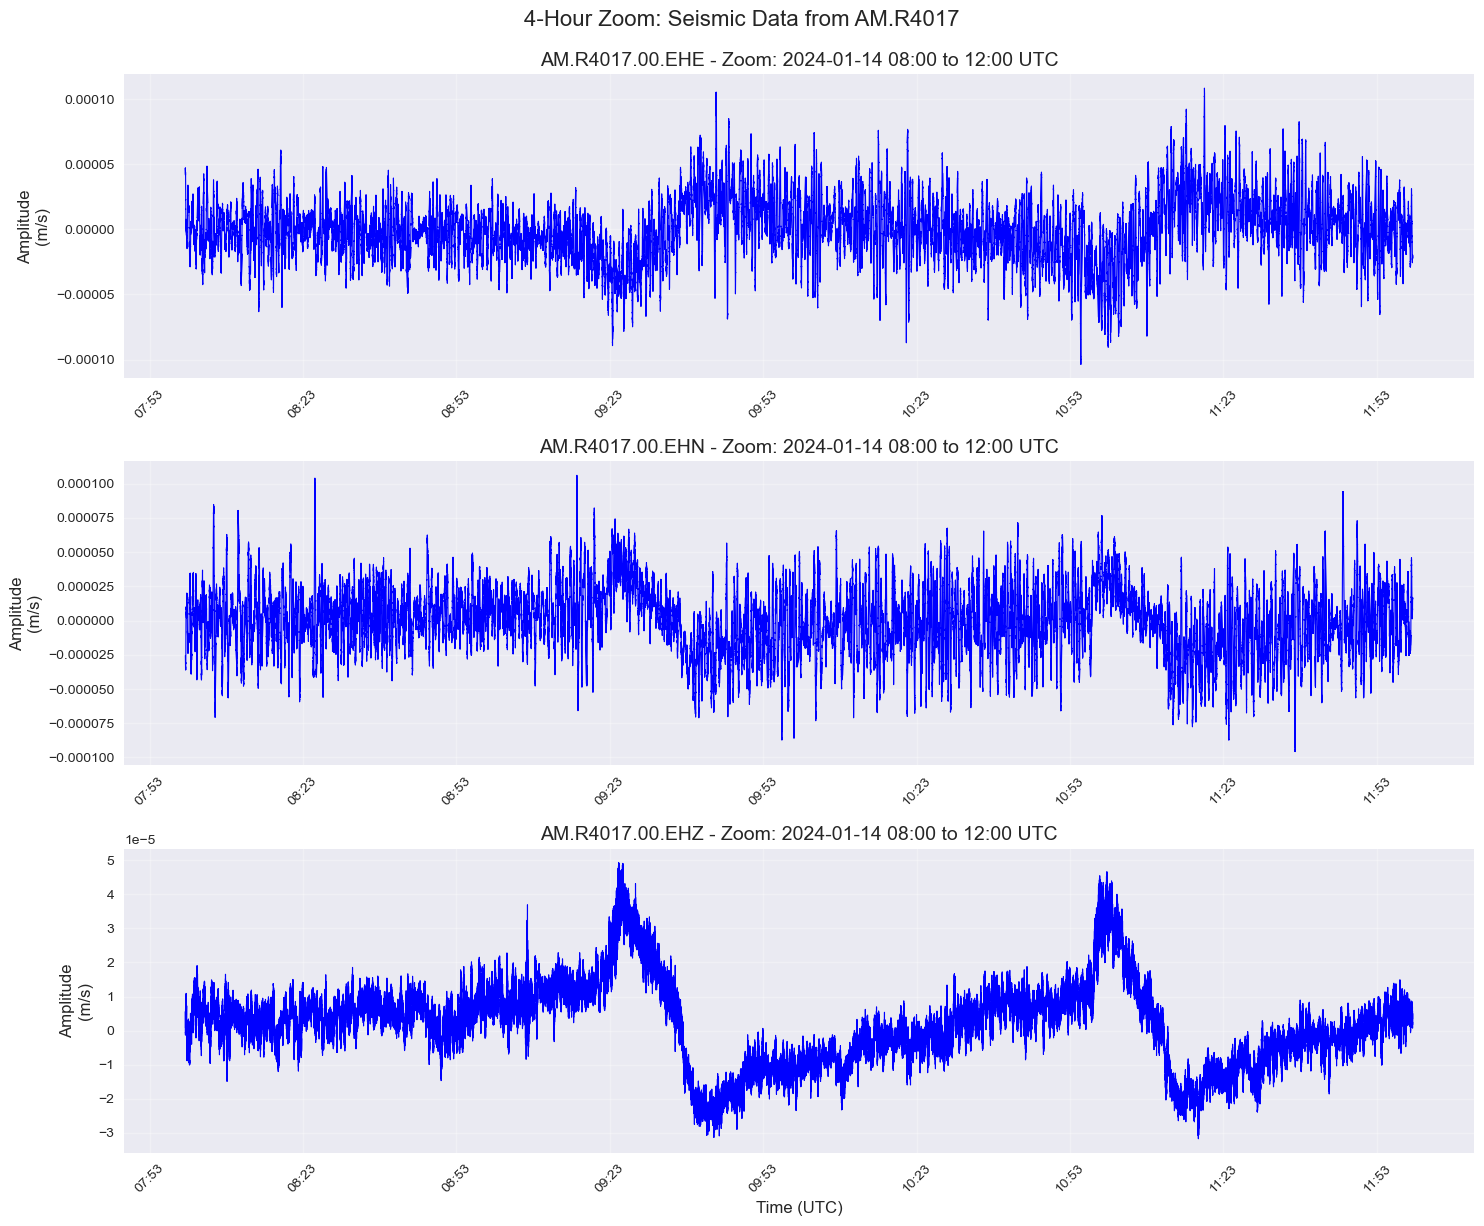

In [8]:
# Plot the complete day of seismic data
fig, axes = plt.subplots(len(stream_processed), 1, figsize=(15, 4*len(stream_processed)))
if len(stream_processed) == 1:
    axes = [axes]

for i, tr in enumerate(stream_processed):
    # Create time array
    times = tr.times("matplotlib")
    
    # Plot the data
    axes[i].plot(times, tr.data, 'b-', linewidth=0.5)
    axes[i].set_title(f'{tr.id} - {tr.stats.starttime.strftime("%Y-%m-%d")}', fontsize=14)
    axes[i].set_ylabel('Amplitude\n(m/s)' if 'response' in locals() else 'Counts', fontsize=12)
    axes[i].grid(True, alpha=0.3)
    
    # Format x-axis
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    axes[i].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)

axes[-1].set_xlabel('Time (UTC)', fontsize=12)
plt.tight_layout()
plt.suptitle(f'24-Hour Seismic Data from {selected_network}.{selected_station}', 
             fontsize=16, y=1.02)
plt.show()

# Plot a zoomed-in view of a few hours
print("\nCreating zoomed view of 4-hour window...")
fig, axes = plt.subplots(len(stream_processed), 1, figsize=(15, 4*len(stream_processed)))
if len(stream_processed) == 1:
    axes = [axes]

# Select 4-hour window (from hour 8 to hour 12)
zoom_start = start_time + 8*3600
zoom_end = start_time + 12*3600

for i, tr in enumerate(stream_processed):
    tr_zoom = tr.slice(zoom_start, zoom_end)
    times = tr_zoom.times("matplotlib")
    
    axes[i].plot(times, tr_zoom.data, 'b-', linewidth=0.8)
    axes[i].set_title(f'{tr.id} - Zoom: {zoom_start.strftime("%Y-%m-%d %H:%M")} to {zoom_end.strftime("%H:%M")} UTC', 
                     fontsize=14)
    axes[i].set_ylabel('Amplitude\n(m/s)' if 'response' in locals() else 'Counts', fontsize=12)
    axes[i].grid(True, alpha=0.3)
    
    # Format x-axis
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    axes[i].xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)

axes[-1].set_xlabel('Time (UTC)', fontsize=12)
plt.tight_layout()
plt.suptitle(f'4-Hour Zoom: Seismic Data from {selected_network}.{selected_station}', 
             fontsize=16, y=1.02)
plt.show()

## Create Spectrograms

Generate spectrograms to visualize the frequency content of the seismic signals over time.

Creating spectrograms...


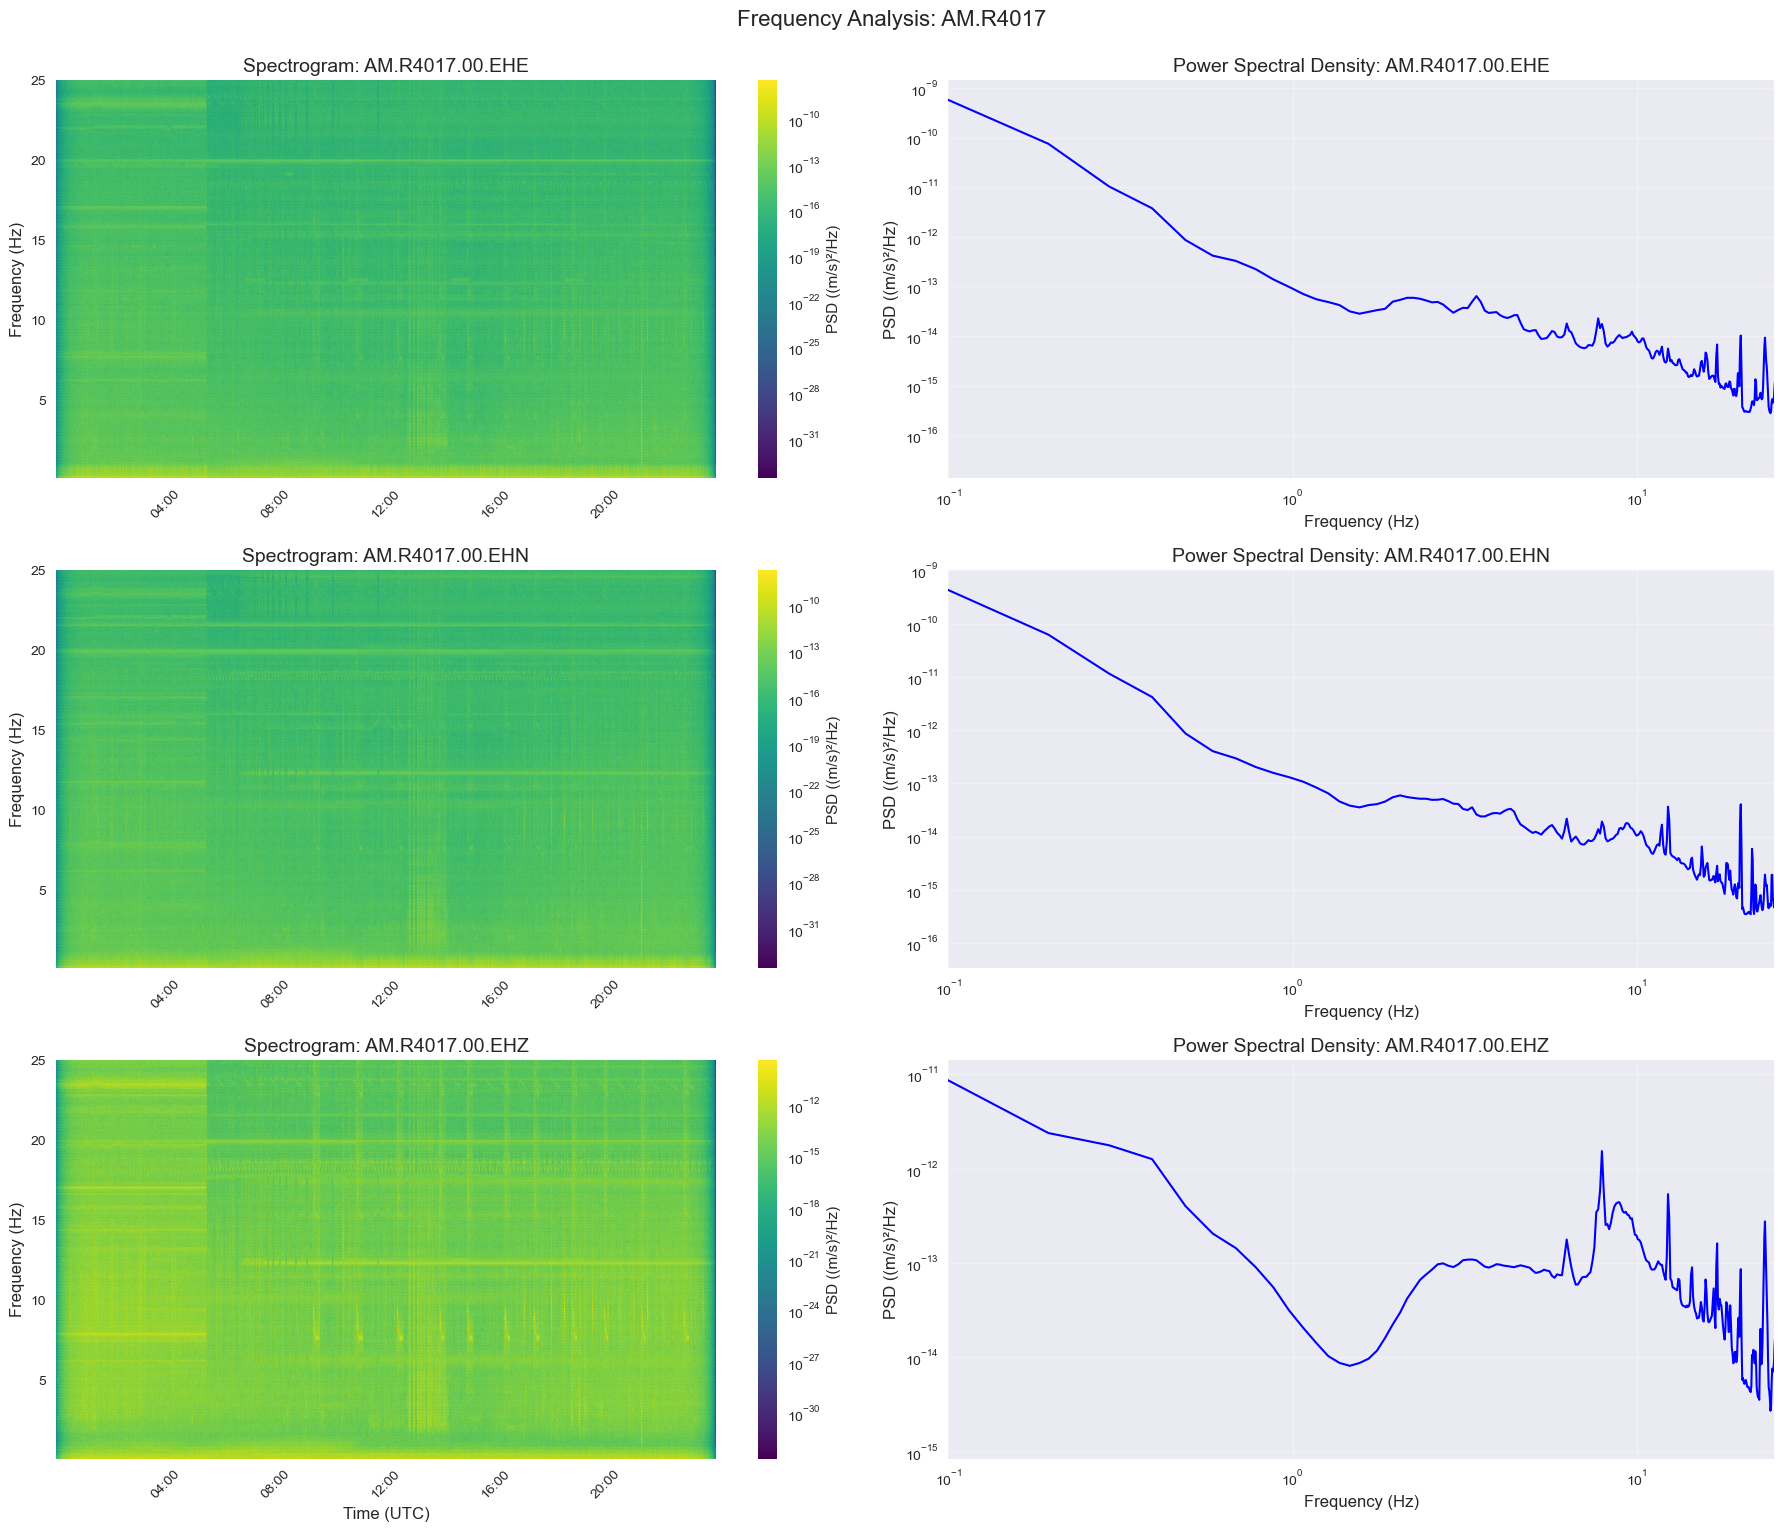

Creating focused spectrogram for 4-hour window...


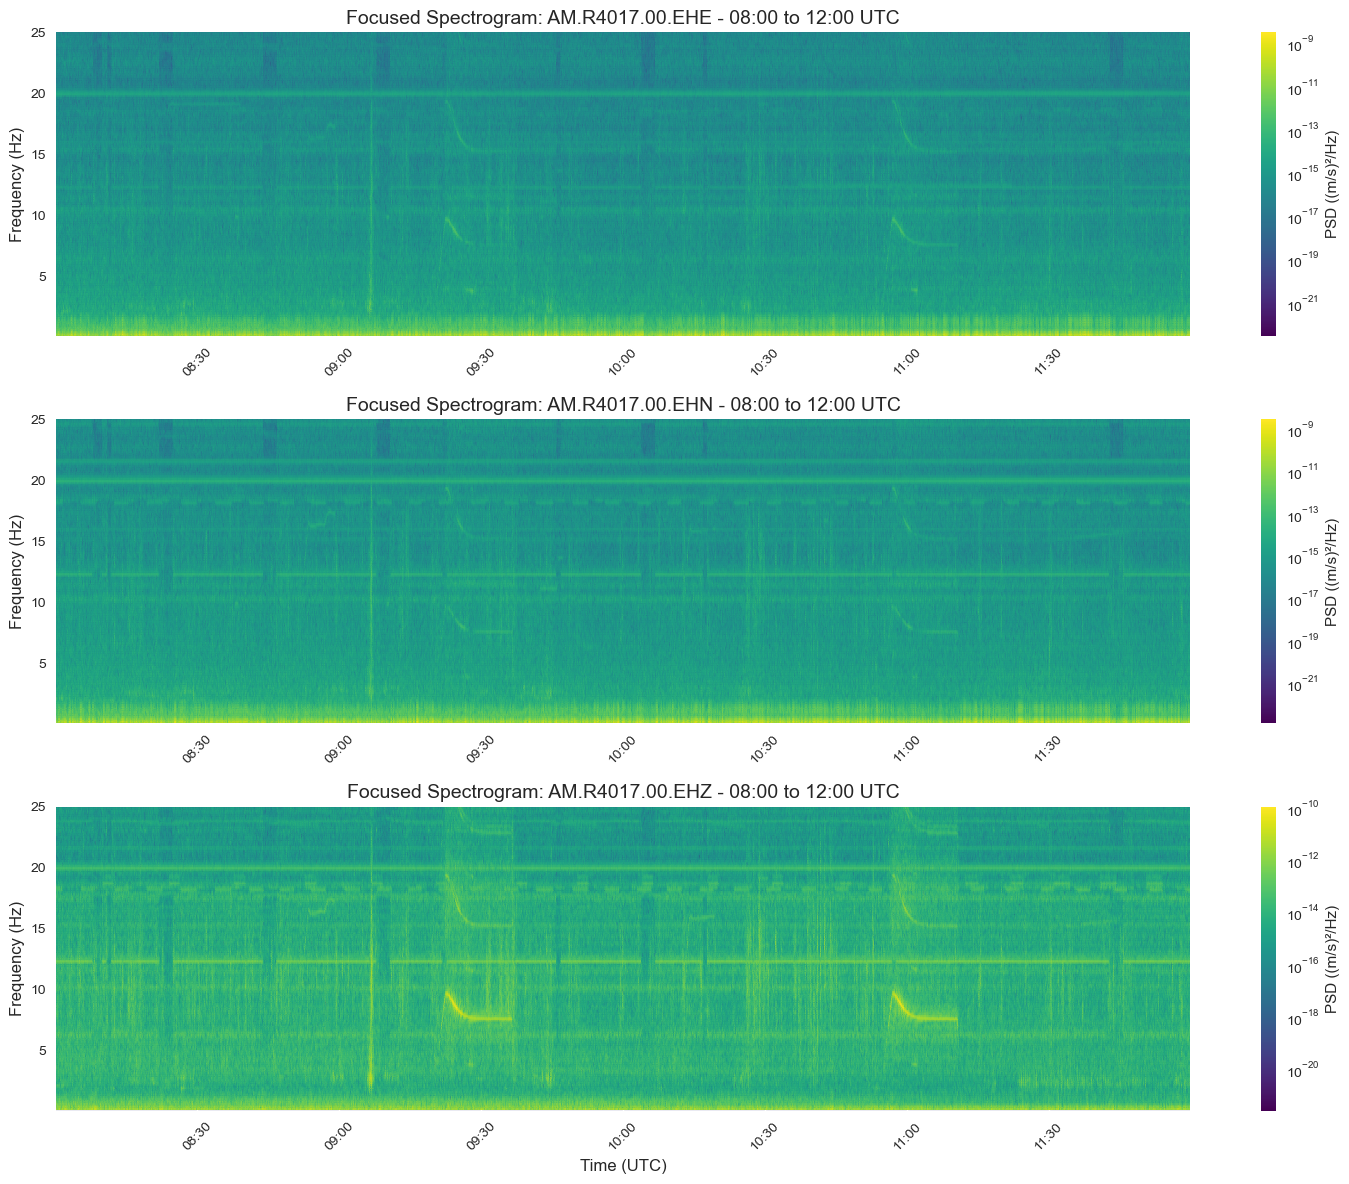

In [9]:
# Create spectrograms for frequency analysis
from scipy import signal
from matplotlib.colors import LogNorm

print("Creating spectrograms...")

# Calculate number of subplots needed
n_traces = len(stream_processed)
fig, axes = plt.subplots(n_traces, 2, figsize=(18, 5*n_traces))
if n_traces == 1:
    axes = axes.reshape(1, -1)

for i, tr in enumerate(stream_processed):
    # Parameters for spectrogram
    nperseg = min(1024, tr.stats.npts // 10)  # Window length
    noverlap = nperseg // 2  # 50% overlap
    
    # Compute spectrogram
    frequencies, times_spec, Sxx = signal.spectrogram(
        tr.data, 
        fs=tr.stats.sampling_rate,
        nperseg=nperseg,
        noverlap=noverlap,
        scaling='density'
    )
    
    # Convert times to matplotlib dates for plotting
    times_spec_mpl = mdates.date2num(tr.stats.starttime.datetime) + times_spec / (24 * 3600)
    
    # Plot spectrogram
    im1 = axes[i, 0].pcolormesh(times_spec_mpl, frequencies[1:], Sxx[1:, :], 
                               norm=LogNorm(), cmap='viridis', shading='gouraud')
    axes[i, 0].set_ylabel('Frequency (Hz)', fontsize=12)
    axes[i, 0].set_title(f'Spectrogram: {tr.id}', fontsize=14)
    axes[i, 0].set_ylim(0.1, min(25, tr.stats.sampling_rate/2))  # Focus on relevant frequencies
    
    # Format x-axis
    axes[i, 0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    axes[i, 0].xaxis.set_major_locator(mdates.HourLocator(interval=4))
    plt.setp(axes[i, 0].xaxis.get_majorticklabels(), rotation=45)
    
    # Add colorbar
    plt.colorbar(im1, ax=axes[i, 0], label='PSD (counts²/Hz)' if 'response' not in locals() else 'PSD ((m/s)²/Hz)')
    
    # Plot Power Spectral Density (averaged over time)
    freqs_psd, psd = signal.welch(tr.data, tr.stats.sampling_rate, nperseg=nperseg)
    axes[i, 1].loglog(freqs_psd[1:], psd[1:], 'b-', linewidth=1.5)
    axes[i, 1].set_xlabel('Frequency (Hz)', fontsize=12)
    axes[i, 1].set_ylabel('PSD (counts²/Hz)' if 'response' not in locals() else 'PSD ((m/s)²/Hz)', fontsize=12)
    axes[i, 1].set_title(f'Power Spectral Density: {tr.id}', fontsize=14)
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].set_xlim(0.1, min(25, tr.stats.sampling_rate/2))

# Set x-label for bottom row
for j in range(2):
    axes[-1, j].set_xlabel('Time (UTC)' if j == 0 else 'Frequency (Hz)', fontsize=12)

plt.tight_layout()
plt.suptitle(f'Frequency Analysis: {selected_network}.{selected_station}', fontsize=16, y=1.02)
plt.show()

# Create a focused spectrogram for the zoomed time window
print("Creating focused spectrogram for 4-hour window...")
fig, axes = plt.subplots(len(stream_processed), 1, figsize=(15, 4*len(stream_processed)))
if len(stream_processed) == 1:
    axes = [axes]

for i, tr in enumerate(stream_processed):
    tr_zoom = tr.slice(zoom_start, zoom_end)
    
    # Compute spectrogram for zoomed data
    frequencies, times_spec, Sxx = signal.spectrogram(
        tr_zoom.data, 
        fs=tr_zoom.stats.sampling_rate,
        nperseg=min(512, tr_zoom.stats.npts // 10),
        noverlap=256,
        scaling='density'
    )
    
    # Convert times to matplotlib dates
    times_spec_mpl = mdates.date2num(tr_zoom.stats.starttime.datetime) + times_spec / (24 * 3600)
    
    # Plot focused spectrogram
    im = axes[i].pcolormesh(times_spec_mpl, frequencies[1:], Sxx[1:, :], 
                           norm=LogNorm(), cmap='viridis', shading='gouraud')
    axes[i].set_ylabel('Frequency (Hz)', fontsize=12)
    axes[i].set_title(f'Focused Spectrogram: {tr.id} - {zoom_start.strftime("%H:%M")} to {zoom_end.strftime("%H:%M")} UTC', 
                     fontsize=14)
    axes[i].set_ylim(0.1, min(25, tr.stats.sampling_rate/2))
    
    # Format x-axis
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    axes[i].xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)
    
    # Add colorbar
    plt.colorbar(im, ax=axes[i], label='PSD (counts²/Hz)' if 'response' not in locals() else 'PSD ((m/s)²/Hz)')

axes[-1].set_xlabel('Time (UTC)', fontsize=12)
plt.tight_layout()
plt.show()

## Filter and Analyze the Data

Apply frequency filters to the data and perform basic seismic analysis.

Applying frequency filters...
Applied High-frequency (5-25 Hz) filter: 5.0-25.0 Hz
Applied High-frequency (5-25 Hz) filter: 5.0-25.0 Hz
Applied Mid-frequency (1-5 Hz) filter: 1.0-5.0 Hz
Applied Mid-frequency (1-5 Hz) filter: 1.0-5.0 Hz
Applied Low-frequency (0.1-1 Hz) filter: 0.1-1.0 Hz
Applied Low-frequency (0.1-1 Hz) filter: 0.1-1.0 Hz
Applied Very low-freq (0.01-0.1 Hz) filter: 0.01-0.1 Hz
Applied Very low-freq (0.01-0.1 Hz) filter: 0.01-0.1 Hz


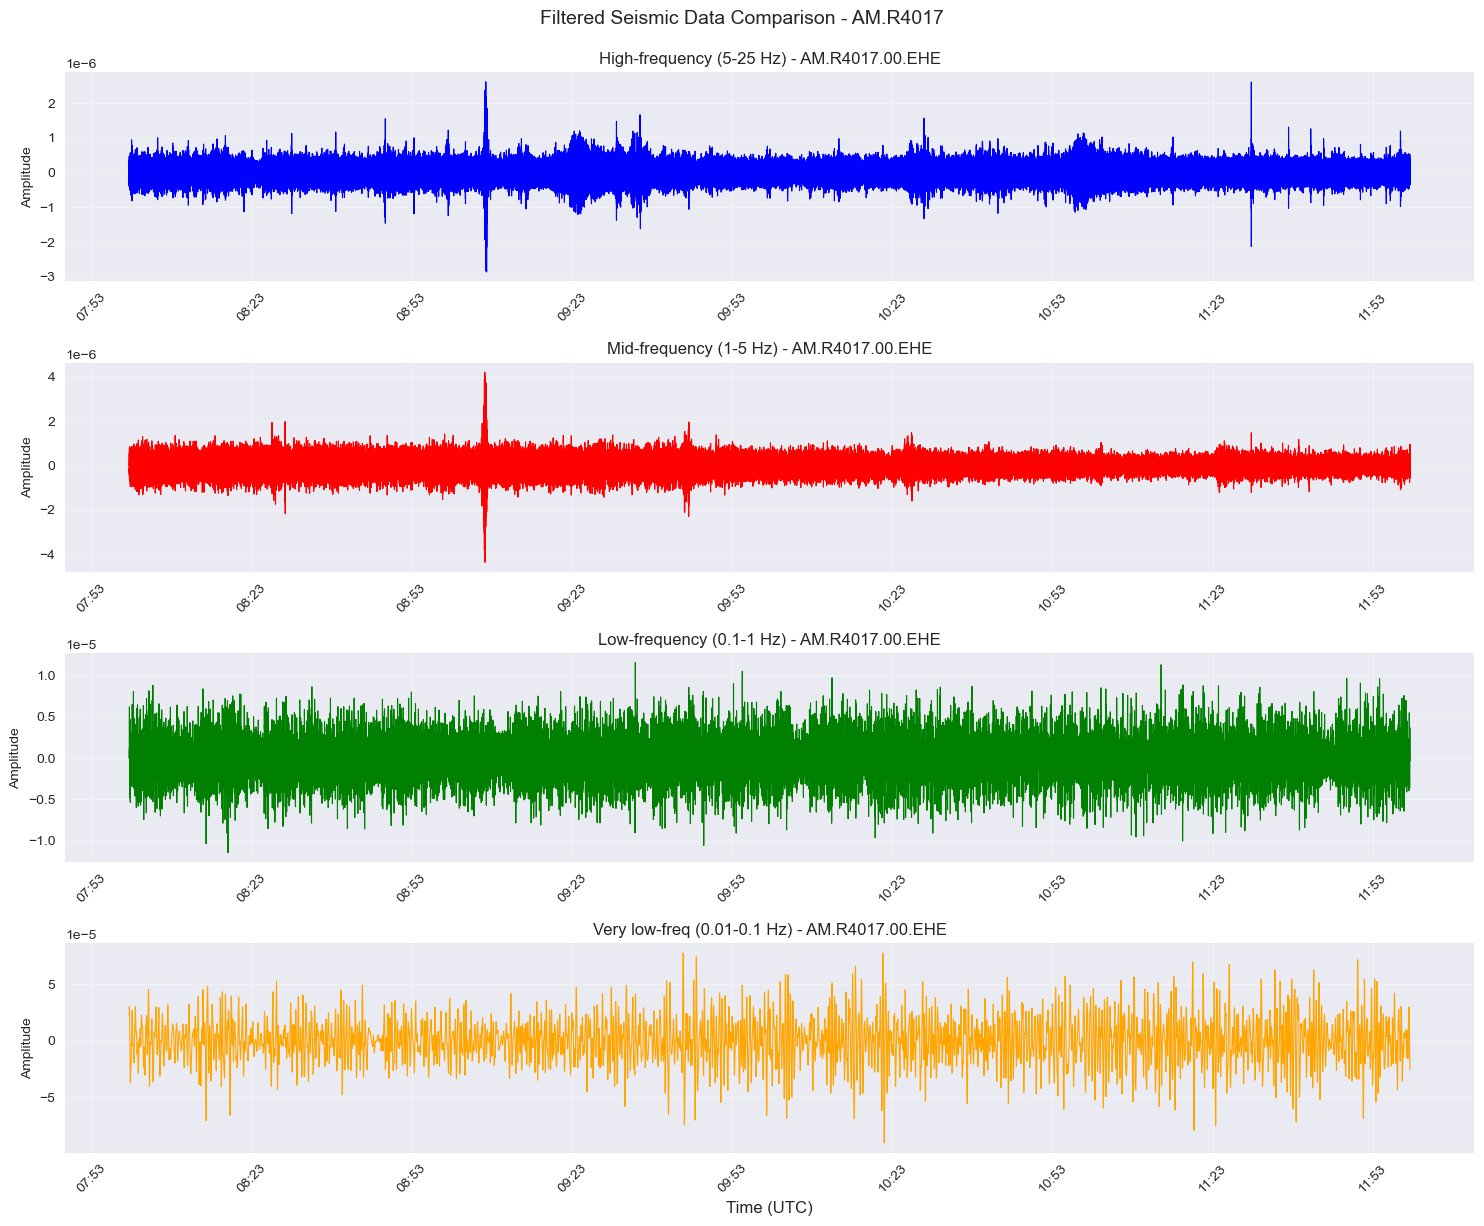


=== RMS Amplitude Analysis ===
Station: AM.R4017
Analysis period: 2024-01-14T00:00:00.000000Z to 2024-01-15T00:00:00.000000Z

High-frequency (5-25 Hz):
  RMS amplitude: 2.90e-07
  Max amplitude: 2.77e-05

Mid-frequency (1-5 Hz):
  RMS amplitude: 3.86e-07
  Max amplitude: 6.39e-05

Low-frequency (0.1-1 Hz):
  RMS amplitude: 2.62e-06
  Max amplitude: 1.32e-05

Very low-freq (0.01-0.1 Hz):
  RMS amplitude: 2.32e-05
  Max amplitude: 1.14e-04

=== Simple Event Detection ===
Detection threshold: 1.37e-06
Number of potential events detected: 247

Detected events:
  Event 1: 2024-01-14T00:36:31.109000Z UTC, amplitude: -5.64e-06
  Event 2: 2024-01-14T00:49:08.669000Z UTC, amplitude: -1.54e-06
  Event 3: 2024-01-14T00:51:02.669000Z UTC, amplitude: 1.57e-06
  Event 4: 2024-01-14T00:56:07.199000Z UTC, amplitude: -1.76e-06
  Event 5: 2024-01-14T00:57:54.349000Z UTC, amplitude: -1.94e-06
  Event 6: 2024-01-14T00:59:39.529000Z UTC, amplitude: -1.70e-06
  Event 7: 2024-01-14T01:01:00.189000Z UTC, amp

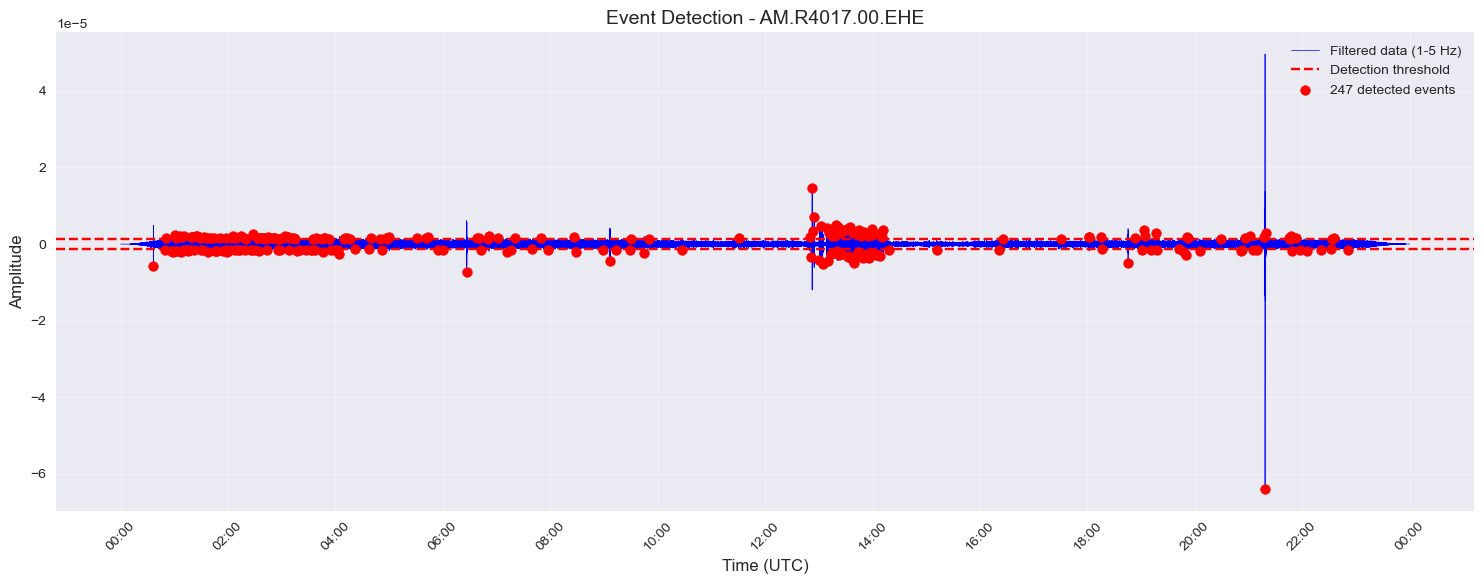


Analysis complete!


In [10]:
# Apply different frequency filters to analyze different types of seismic signals
print("Applying frequency filters...")

# Define filter bands
filter_bands = {
    'High-frequency (5-25 Hz)': [5.0, 25.0],      # Local earthquakes, nearby activity
    'Mid-frequency (1-5 Hz)': [1.0, 5.0],         # Regional earthquakes
    'Low-frequency (0.1-1 Hz)': [0.1, 1.0],       # Teleseismic earthquakes, long-period noise
    'Very low-freq (0.01-0.1 Hz)': [0.01, 0.1]    # Very long period signals
}

# Create filtered versions
filtered_streams = {}
for band_name, freq_range in filter_bands.items():
    try:
        filtered_stream = stream_processed.copy()
        filtered_stream.filter('bandpass', freqmin=freq_range[0], freqmax=freq_range[1], corners=4)
        filtered_streams[band_name] = filtered_stream
        print(f"Applied {band_name} filter: {freq_range[0]}-{freq_range[1]} Hz")
    except Exception as e:
        print(f"Could not apply {band_name} filter: {e}")

# Plot filtered data comparison
fig, axes = plt.subplots(len(filtered_streams), 1, figsize=(15, 3*len(filtered_streams)))
if len(filtered_streams) == 1:
    axes = [axes]

colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, (band_name, filt_stream) in enumerate(filtered_streams.items()):
    # Use the first trace for plotting
    tr = filt_stream[0]
    tr_zoom = tr.slice(zoom_start, zoom_end)  # Use the same 4-hour window
    times = tr_zoom.times("matplotlib")
    
    axes[i].plot(times, tr_zoom.data, color=colors[i % len(colors)], linewidth=0.8)
    axes[i].set_title(f'{band_name} - {tr.id}', fontsize=12)
    axes[i].set_ylabel('Amplitude', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    
    # Format x-axis
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    axes[i].xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)

axes[-1].set_xlabel('Time (UTC)', fontsize=12)
plt.tight_layout()
plt.suptitle(f'Filtered Seismic Data Comparison - {selected_network}.{selected_station}', 
             fontsize=14, y=1.02)
plt.show()

# Calculate and display RMS amplitudes for different frequency bands
print("\n=== RMS Amplitude Analysis ===")
print(f"Station: {selected_network}.{selected_station}")
print(f"Analysis period: {start_time} to {end_time}")
print()

for band_name, filt_stream in filtered_streams.items():
    tr = filt_stream[0]  # Use first trace
    rms_amplitude = np.sqrt(np.mean(tr.data**2))
    max_amplitude = np.max(np.abs(tr.data))
    
    print(f"{band_name}:")
    print(f"  RMS amplitude: {rms_amplitude:.2e}")
    print(f"  Max amplitude: {max_amplitude:.2e}")
    print()

# Simple event detection based on amplitude threshold
print("=== Simple Event Detection ===")
# Use the mid-frequency band for event detection
if 'Mid-frequency (1-5 Hz)' in filtered_streams:
    tr_detect = filtered_streams['Mid-frequency (1-5 Hz)'][0]
    
    # Calculate threshold as multiple of background noise level
    # Use median absolute deviation as robust noise estimate
    mad = np.median(np.abs(tr_detect.data - np.median(tr_detect.data)))
    threshold = 5 * mad * 1.4826  # 1.4826 converts MAD to standard deviation
    
    # Find peaks above threshold
    from scipy.signal import find_peaks
    peaks, properties = find_peaks(np.abs(tr_detect.data), 
                                  height=threshold, 
                                  distance=int(60 * tr_detect.stats.sampling_rate))  # At least 60s apart
    
    print(f"Detection threshold: {threshold:.2e}")
    print(f"Number of potential events detected: {len(peaks)}")
    
    if len(peaks) > 0:
        print("\nDetected events:")
        for i, peak_idx in enumerate(peaks):
            event_time = tr_detect.stats.starttime + peak_idx / tr_detect.stats.sampling_rate
            amplitude = tr_detect.data[peak_idx]
            print(f"  Event {i+1}: {event_time} UTC, amplitude: {amplitude:.2e}")
    else:
        print("No significant events detected above threshold")
        
    # Plot detection results
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    
    # Plot full day with detections
    times_full = tr_detect.times("matplotlib")
    ax.plot(times_full, tr_detect.data, 'b-', linewidth=0.5, label='Filtered data (1-5 Hz)')
    ax.axhline(threshold, color='r', linestyle='--', label=f'Detection threshold')
    ax.axhline(-threshold, color='r', linestyle='--')
    
    # Mark detected events
    if len(peaks) > 0:
        peak_times = [tr_detect.stats.starttime.matplotlib_date + peak_idx / (tr_detect.stats.sampling_rate * 24 * 3600) for peak_idx in peaks]
        peak_amplitudes = [tr_detect.data[peak_idx] for peak_idx in peaks]
        ax.scatter(peak_times, peak_amplitudes, color='red', s=50, zorder=5, label=f'{len(peaks)} detected events')
    
    ax.set_xlabel('Time (UTC)', fontsize=12)
    ax.set_ylabel('Amplitude', fontsize=12)
    ax.set_title(f'Event Detection - {tr_detect.id}', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

else:
    print("Mid-frequency filtered data not available for event detection")

print("\nAnalysis complete!")

## Summary and Next Steps

This notebook demonstrated how to:

1. **Connect to FDSN services** - Access Raspberry Shake data through their FDSN web service
2. **Download seismic data** - Retrieve a full day of waveform data from an Anchorage area sensor
3. **Process the data** - Apply basic preprocessing steps including detrending and tapering
4. **Visualize waveforms** - Create time series plots for the complete dataset and zoomed views
5. **Frequency analysis** - Generate spectrograms and power spectral density plots
6. **Filter analysis** - Apply different frequency filters to isolate various types of seismic signals
7. **Event detection** - Implement simple amplitude-based event detection

### Key Observations:
- Seismic data contains various frequency components from different sources
- High-frequency signals (5-25 Hz) often represent local seismic activity
- Low-frequency signals (0.1-1 Hz) may indicate distant earthquakes or long-period noise
- Spectrograms reveal the time-varying frequency content of seismic signals

### Potential Next Steps:
- **Machine Learning Integration**: Use this data with the CNN models in this repository for automated seismic event classification
- **Real-time Processing**: Implement streaming data processing for continuous monitoring
- **Multi-station Analysis**: Compare data from multiple Raspberry Shake stations
- **Advanced Event Detection**: Implement more sophisticated detection algorithms (STA/LTA, template matching)
- **Earthquake Catalog Comparison**: Cross-reference detected events with official earthquake catalogs

### Resources:
- [Raspberry Shake Data Portal](https://raspberryshake.net/)
- [ObsPy Documentation](https://docs.obspy.org/)
- [FDSN Web Services](https://www.fdsn.org/webservices/)

---

*This notebook provides a foundation for seismic data analysis that can be extended for various research and monitoring applications.*